# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

**План исследования**

Предварительный осмотр данных

- соберем общую информацию о данных 
- оценим нехватку или избыточность данных
- определим явно некорректные данные

Обработка данных

- определим и заполните пропущенные значения
- заменим типы данных для оптимизации хранения датасет в оперативной памяти
- удалим дубликаты
- проведем лемматизацию и категоризацию данных

Вопросы на которые небходимо найти ответы в ходе анализа данных

- Есть ли зависимость между наличием детей и возвратом кредита в срок?
- Есть ли зависимость между семейным положением и возвратом кредита в срок?
- Как разные цели кредита влияют на его возврат в срок?
- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Составить общий вывод





## Шаг 1. Откройте файл с данными и изучите общую информацию

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pymystem3 import Mystem

In [3]:
local = False
if local:
    df = pd.read_csv('/datasets/data.csv')
else:
    url = "https://drive.google.com/file/d/1ubqd5ljA7DlzyI6lRsIK99iwCkAkhTD5/view?usp=sharing"
    path = 'https://drive.google.com/uc?export=download&id='+ url.split('/')[-2]
    df = pd.read_csv(path)

In [4]:
df.head(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


Описание данных в исходном файле

• children — количество детей в семье • days_employed — общий трудовой стаж в днях • dob_years — возраст клиента в годах • education — уровень образования клиента • education_id — идентификатор уровня образования • family_status — семейное положение • family_status_id — идентификатор семейного положения • gender — пол клиента • income_type — тип занятости • debt — имел ли задолженность по возврату кредитов • total_income — ежемесячный доход • purpose — цель получения кредита

In [222]:
#оценим lдатасет в целом
df.info()
#уже видно нехватку данных в столбцах days_employed и total_income      

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [223]:
#оценим макисмумы, минимумы и среднее по столбцам
df.describe().T
#видим странные отрицательные значения в столбцах с количеством детей и в трудовом стаже
#кроме того, 20 в максимуме - явный перебор

,count,mean,std,min,25%,50%,75%,max
children,21525.0,0.538908,1.381587,-1.000000,0.000000,0.000000,1.000000,2.000000e+01
days_employed,19351.0,63046.497661,140827.311974,-18388.949901,-2747.423625,-1203.369529,-291.095954,4.017554e+05
dob_years,21525.0,43.293380,12.574584,0.000000,33.000000,42.000000,53.000000,7.500000e+01
education_id,21525.0,0.817236,0.548138,0.000000,1.000000,1.000000,1.000000,4.000000e+00
family_status_id,21525.0,0.972544,1.420324,0.000000,0.000000,0.000000,1.000000,4.000000e+00
debt,21525.0,0.080883,0.272661,0.000000,0.000000,0.000000,0.000000,1.000000e+00
total_income,19351.0,167422.302208,102971.566448,20667.263793,103053.152913,145017.937533,203435.067663,2.265604e+06


In [224]:
#опираясь на общую информацию по info()
#посмотрим на NaN в столбцах total_income и days_employed
#NaN присутствует одновременно в двух столбцах
df.loc[df['total_income'].isna()]
df.head(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [225]:
#странный отрицательный стаж
df.loc[df.loc[:,'days_employed'] < 0]['income_type'].value_counts()

сотрудник          10014
компаньон           4577
госслужащий         1312
предприниматель        1
в декрете              1
студент                1
Name: income_type, dtype: int64

In [226]:
#положительный стаж по двум видам занятости
df.loc[df.loc[:,'days_employed'] > 0]['income_type'].value_counts()

пенсионер      3443
безработный       2
Name: income_type, dtype: int64

In [227]:
#наличие отрицательных детей в большом количестве строк
df.loc[df.loc[:,'children'] < 0]['income_type'].value_counts()

сотрудник      26
компаньон       9
пенсионер       8
госслужащий     4
Name: income_type, dtype: int64

In [230]:
#оценим количество строк с количеством детей больше 10
df.loc[(df.loc[:,'children'] > 10) & (df.loc[:,'children'] <= 20) ]['income_type'].value_counts()

сотрудник      43
компаньон      22
пенсионер       9
госслужащий     2
Name: income_type, dtype: int64

In [231]:
#не структурированы данные в столбце образование
#привести к нижнему регистру
df['education'].value_counts()

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64

**Вывод**

Выявлен список проблем:

children - отрицательные значения в детях, кроме того странный 'выброс' от 10 до 20 детей

days_employed - отрицательные значения, NaN в количестве 2174 строк. Необходимо преобразовать в тип Int и добавить колонку с измерением год, для более удобной оценки

total_incomу - убрать NaN (по-видимому синхронизирован с NaN в колонке days_employed). Заменить на значение 0.

education - преобразовать в нижний регистр, убрать дубли

family_status - преобразовать в нижний регистр

dob_years - странный нулевой возраст в минимальном значении

purpose - Необходимо классифицировать по нескольким признакам ('оцифровать')

## Шаг 2. Предобработка данных

### Обработка пропусков

Посмотрим типы занятости (income_type) по которым идут пропуски в колонках стаж и доход

In [232]:
df.loc[df['total_income'].isna()].groupby('income_type')['income_type'].count()

income_type
госслужащий         147
компаньон           508
пенсионер           413
предприниматель       1
сотрудник          1105
Name: income_type, dtype: int64

Посмотрим укрупненно возраста по которым идут пропуски в колонках стаж и доход

In [233]:
def age_group(row):
    if row['dob_years'] < 18:
        return 'до 18'
    elif 18 <= row['dob_years'] & row['dob_years'] < 25:
        return '18-25'
    elif 25 <= row['dob_years'] & row['dob_years'] < 35:
        return '25-35'
    elif 35 <= row['dob_years'] & row['dob_years'] < 45:
        return '35-45'
    elif 45 <= row['dob_years'] & row['dob_years'] < 55:
        return '45-55'
    elif 55 <= row['dob_years'] & row['dob_years'] < 65:
        return '55-65'
    else:
        return '65 и старше'
df['age_groupe'] = df.apply(age_group, axis=1) 

df.loc[df['total_income'].isna()].groupby('age_groupe')['age_groupe'].count()

age_groupe
18-25           98
25-35          481
35-45          569
45-55          506
55-65          429
65 и старше     81
до 18           10
Name: age_groupe, dtype: int64

In [234]:
#Оценим кооличество строк с NaN
Count_Raws_NaN = df.loc[df['total_income'].isna()].shape[0]
print('Количество строк с NaN = {}'.format(Count_Raws_NaN))
#посмотрим долю таких строк
try:
    print('Доля строк с NaN от общего количества строк = {:.2%}'.format(Count_Raws_NaN/df.shape[0]))
except:
    print('Ошибка: деление на 0')

Количество строк с NaN = 2174
Доля строк с NaN от общего количества строк = 10.10%


Сделаем промежуточный вывод:

Пропуски присутствуют во всех возрастных группах и типах занятости. Кроме того, количество таких строк составляет 10% от всего датасет! По - видимому, удалять строки с NaN, всё-таки нецелесообразно. Поэтому NaN заменим на нули.

In [235]:
df['total_income'] = df['total_income'].fillna(0)

In [236]:
df['days_employed'] = df['days_employed'].fillna(0)

In [237]:
Count_Raws_NaN = df.loc[df['total_income'].isna()].shape[0]
#проверяем
print('Количество строк с NaN = {}'.format(Count_Raws_NaN))

Количество строк с NaN = 0


**Вывод**

Принято решение не удалять строки с NaN. Так как, это составляет 10% от всего имеющегося датасет. И NаN встречается во всех возрастных группах и видах занятости. NaN заменен на 0.

### Замена типа данных

In [238]:
#столбец с доходами (total_income)
#преобразуем к типу int, копейками принебрежем, так как это не расчеты в бухгалтерии 1C
df['total_income'] = df['total_income'].astype('int')
#проверим получивщиеся типы
#df.info()

In [239]:
#столбец с возрастом (dob_years)
#преобразуем к типу int с округлением
df['dob_years'] = df['dob_years'].astype('int')

In [240]:
# Разберемся со стажем. Ранее было выяснено, что положительный стаж имеют пенсионеры и безработные, а отрицательный 
# все остальные типы занятых. 
# Предположим, что отрицательные значения - ошибки ввода данных из разных источников. 
# В рамках нашей задачи такая разбивка не нужна.
# Приведем всех к положительным значениям.
# 
df['days_employed'] = df['days_employed'].abs()

#переведем стаж в года, добавим новую колонку
df['years_employed'] = df['days_employed']/365
df['years_employed'] = df['years_employed'].astype('int')
#посмотрим на цифры
df['years_employed'].describe()


count    21525.000000
mean       164.362602
std        365.337729
min          0.000000
25%          1.000000
50%          4.000000
75%         13.000000
max       1100.000000
Name: years_employed, dtype: float64

In [241]:
# Есть те, кто начал работать ещё при Рюрике. 
# Посмотрим количество таких 'стахановцев'. И распределим по полу. Считать 'count' будем по колонке gender
result = df.loc[df['years_employed'] > 60 ]['gender'].value_counts()
print(result)

F    2807
M     638
Name: gender, dtype: int64


In [242]:
total_older=0
#type(len(result))
for sex_index in range(0,len(result)):
    total_older += result[sex_index]
print('Количество записей с трудовым стажем > 60 лет = {}'.format(total_older))
print('Процент записей с трудовым стажем > 60 лет = {:.2%}'.format(total_older/df.shape[0]))

Количество записей с трудовым стажем > 60 лет = 3445
Процент записей с трудовым стажем > 60 лет = 16.00%


In [243]:
#удалим колонку стажа в днях 
del df['days_employed']

Сделаем промежуточный вывод:

Количество записей с огромным трудовым стажем составляет 16%. Удалять такое количество странных записей - нельзя. Так как в 
постановке задачи нет подзадачи связанной с трудовым стажем. И записи разбросаны по всему датасет.

In [244]:
#приведем колонку образование к нижнему регистру
df['education'] = df['education'].str.lower()

In [245]:
#оценим результат
df['education'].unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

In [246]:
#после преобразования столбца education столбец education_id стал избыточным
df['education_id'].unique()

array([0, 1, 2, 3, 4])

In [247]:
#приведем колонку семейное положение к нижнему регистру
df['family_status'] = df['family_status'].str.lower()

In [248]:
df['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'не женат / не замужем'], dtype=object)

In [249]:
#приведем колонку цель получения кредита к нижнему регистру
df['purpose'] = df['purpose'].str.lower()

In [250]:
df['gender'].unique()

array(['F', 'M', 'XNA'], dtype=object)

In [251]:
#всего одна запись с непонятным полом
df[df['gender'] == 'XNA']['gender'].count()

1

In [252]:
#отрицательное количество детей переведем в положительное
df['children'] = df['children'].abs()

In [253]:
#20 заменим на 2. По-видимому 2.0 превратилось в строку '20' и затем в число 20
df['children'] = df['children'].replace(20, 2)

In [254]:
#привели детей к нормальному количеству
df['children'].unique()

array([1, 0, 3, 2, 4, 5])

In [255]:
#посмотрим что получилось
df.head(5)

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_groupe,years_employed
0,1,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,35-45,23
1,1,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,35-45,11
2,0,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,25-35,15
3,3,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,25-35,11
4,0,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,45-55,932


In [256]:
#было 11.3 MB
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 13 columns):
children            21525 non-null int64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null int64
purpose             21525 non-null object
age_groupe          21525 non-null object
years_employed      21525 non-null int64
dtypes: int64(7), object(6)
memory usage: 13.9 MB


In [257]:
# uint8 - беззнаковое целое (числа размером 1 байт).

df['family_status_id'] = df['family_status_id'].astype('uint8')
df['children'] = df['children'].astype('uint8')
df['debt'] = df['debt'].astype('uint8')
df['education_id'] = df['education_id'].astype('uint8')
df['dob_years'] = df['dob_years'].astype('uint8')

# uint16
# беззнаковое целые числа в диапазоне от -32768 по 32767, (числа размером 2 байта).
df['years_employed'] = df['years_employed'].astype('uint16')

# uint32
# беззнаковое целые числа в диапазоне от 0 по 4294967295 (числа размером 4 байта).
df['total_income'] = df['total_income'].astype('uint32')

#category - для фиксированного набора строк
df['family_status'] = df['family_status'].astype('category')
df['education'] = df['education'].astype('category')
df['income_type'] = df['income_type'].astype('category')

#колонку purpose можно также поджать, но после лемматизации..
#df['purpose'] = df['purpose'].astype('category')

In [270]:
#стало 5.4 MB
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21454 entries, 0 to 21453
Data columns (total 13 columns):
children            21454 non-null uint8
dob_years           21454 non-null uint8
education           21454 non-null category
education_id        21454 non-null uint8
family_status       21454 non-null category
family_status_id    21454 non-null uint8
gender              21454 non-null object
income_type         21454 non-null category
debt                21454 non-null uint8
total_income        21454 non-null uint32
age_groupe          21454 non-null object
years_employed      21454 non-null uint16
credit_purpose      21454 non-null object
dtypes: category(3), object(3), uint16(1), uint32(1), uint8(5)
memory usage: 4.9 MB


Вывод (для себя): Следует использовать тип 'category' для фиксированного набора значений в столбцах. Замена int64 даже на uint8 не так эффективна, как преобразование в 'category'

**Вывод**

Датасет подготовлен к обработке дубликатов

### Обработка дубликатов

In [260]:
#подсчитаем количество полных дублей
df.duplicated().sum()

71

In [261]:
#удалим дубли с индексацией датасет
df = df.drop_duplicates().reset_index(drop = True)

In [262]:
#проверим наличие дублей
df.duplicated().sum()

0

**Вывод**

Дубли успешно удалены

### Лемматизация

In [263]:
# Узнаем количество уникальных значений в столбце purpose
array_unique_purpose = df['purpose'].unique()
list_purpose = array_unique_purpose.tolist()
list_purpose.sort()
for purpose in list_purpose:
    print(purpose)

автомобили
автомобиль
высшее образование
дополнительное образование
жилье
заняться высшим образованием
заняться образованием
на покупку автомобиля
на покупку подержанного автомобиля
на покупку своего автомобиля
на проведение свадьбы
недвижимость
образование
операции с жильем
операции с коммерческой недвижимостью
операции с недвижимостью
операции со своей недвижимостью
покупка жилой недвижимости
покупка жилья
покупка жилья для сдачи
покупка жилья для семьи
покупка коммерческой недвижимости
покупка недвижимости
покупка своего жилья
получение высшего образования
получение дополнительного образования
получение образования
приобретение автомобиля
профильное образование
ремонт жилью
свадьба
свой автомобиль
сделка с автомобилем
сделка с подержанным автомобилем
строительство жилой недвижимости
строительство недвижимости
строительство собственной недвижимости
сыграть свадьбу


Очевидно, что есть цели получения кредита дублирующие друг друга.

Выделим похожие цели через механизм лемматизации

In [264]:
#импортируем библиотеку pymystem3

#from pymystem3 import Mystem - код перенесен в начало проекта
m = Mystem() 

for query in list_purpose:
    lemmas = m.lemmatize(query)
    print(lemmas)
 

['автомобиль', '\n']
['автомобиль', '\n']
['высокий', ' ', 'образование', '\n']
['дополнительный', ' ', 'образование', '\n']
['жилье', '\n']
['заниматься', ' ', 'высокий', ' ', 'образование', '\n']
['заниматься', ' ', 'образование', '\n']
['на', ' ', 'покупка', ' ', 'автомобиль', '\n']
['на', ' ', 'покупка', ' ', 'подержать', ' ', 'автомобиль', '\n']
['на', ' ', 'покупка', ' ', 'свой', ' ', 'автомобиль', '\n']
['на', ' ', 'проведение', ' ', 'свадьба', '\n']
['недвижимость', '\n']
['образование', '\n']
['операция', ' ', 'с', ' ', 'жилье', '\n']
['операция', ' ', 'с', ' ', 'коммерческий', ' ', 'недвижимость', '\n']
['операция', ' ', 'с', ' ', 'недвижимость', '\n']
['операция', ' ', 'со', ' ', 'свой', ' ', 'недвижимость', '\n']
['покупка', ' ', 'жилой', ' ', 'недвижимость', '\n']
['покупка', ' ', 'жилье', '\n']
['покупка', ' ', 'жилье', ' ', 'для', ' ', 'сдача', '\n']
['покупка', ' ', 'жилье', ' ', 'для', ' ', 'семья', '\n']
['покупка', ' ', 'коммерческий', ' ', 'недвижимость', '\n']
['по

In [265]:
#Выделим основные, наиболее часто встречающиеся слова в список
words_list = ['автомобиль','недвижимость','жилье','образование','свадьба','иное']
words_list # 0,1,2,3,4,5

['автомобиль', 'недвижимость', 'жилье', 'образование', 'свадьба', 'иное']

In [266]:
#составим словарь где ключами будут уникальные значения list_purpose, а значениями - words_list

dictionary_purpose = {}
for purpose in list_purpose:
    if 'авто' in purpose:
         dictionary_purpose[purpose] = words_list[0] #'автомобиль'
    elif 'недвиж' in purpose:
         dictionary_purpose[purpose] = words_list[1] #'недвижимость'
    elif 'жиль' in purpose:
         dictionary_purpose[purpose] = words_list[2] #'жилье'
    elif 'образован' in purpose:
        dictionary_purpose[purpose] = words_list[3] #'образование'
    elif 'свадьб' in purpose:
         dictionary_purpose[purpose] = words_list[4] #'свадьба'
    else:
         dictionary_purpose[purpose] = words_list[5] #'иное'

print(dictionary_purpose)

{'автомобили': 'автомобиль', 'автомобиль': 'автомобиль', 'высшее образование': 'образование', 'дополнительное образование': 'образование', 'жилье': 'жилье', 'заняться высшим образованием': 'образование', 'заняться образованием': 'образование', 'на покупку автомобиля': 'автомобиль', 'на покупку подержанного автомобиля': 'автомобиль', 'на покупку своего автомобиля': 'автомобиль', 'на проведение свадьбы': 'свадьба', 'недвижимость': 'недвижимость', 'образование': 'образование', 'операции с жильем': 'жилье', 'операции с коммерческой недвижимостью': 'недвижимость', 'операции с недвижимостью': 'недвижимость', 'операции со своей недвижимостью': 'недвижимость', 'покупка жилой недвижимости': 'недвижимость', 'покупка жилья': 'жилье', 'покупка жилья для сдачи': 'жилье', 'покупка жилья для семьи': 'жилье', 'покупка коммерческой недвижимости': 'недвижимость', 'покупка недвижимости': 'недвижимость', 'покупка своего жилья': 'жилье', 'получение высшего образования': 'образование', 'получение дополнител

In [267]:
#добавим новую колонку и заполним её по словарю
df['credit_purpose'] = df['purpose'].map(dictionary_purpose)

In [268]:
del df['purpose']

In [269]:
df.head()

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,age_groupe,years_employed,credit_purpose
0,1,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,35-45,23,жилье
1,1,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,35-45,11,автомобиль
2,0,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,25-35,15,жилье
3,3,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,25-35,11,образование
4,0,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,45-55,932,свадьба


**Вывод**

Проведена лемматицация по колонке цель кредита, добавлена новая колока с перечислением ограниченного количества целей.

### Категоризация данных

Text(0, 0.5, 'Количество в выборке')

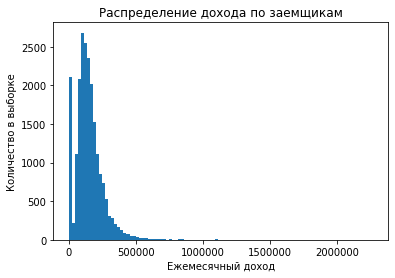

In [316]:
df['total_income'].plot(kind='hist', bins=100)
plt.title('Распределение дохода по заемщикам')
plt.xlabel('Ежемесячный доход')
plt.ylabel('Количество в выборке')

Text(0, 0.5, 'Количество в выборке')

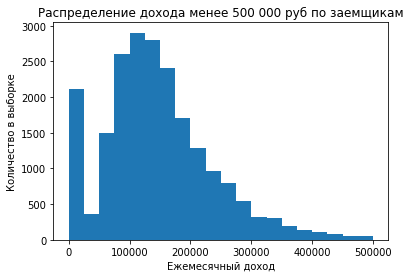

In [318]:
#ограничим верхнюю планку в 500 000
df2 = df.loc[df.loc[:,'total_income'] < 500000]
df2['total_income'].plot(kind='hist', bins=20)
plt.title('Распределение дохода менее 500 000 руб по заемщикам')
plt.xlabel('Ежемесячный доход')
plt.ylabel('Количество в выборке')


In [297]:
#оценим через describe()
series_of_level_income = df['total_income'].describe()
series_of_level_income

count    2.145400e+04
mean     1.510105e+05
std      1.097366e+05
min      0.000000e+00
25%      8.908850e+04
50%      1.357810e+05
75%      1.958132e+05
max      2.265604e+06
Name: total_income, dtype: float64

In [298]:
#посмотрим цифры 
print('низкий доход = {:.2f}'.format(series_of_level_income['25%']))
print('средний доход = {:.2f}'.format(series_of_level_income['50%']))
print('высокий доход = {:.2f}'.format(series_of_level_income['75%']))


низкий доход = 89088.50
средний доход = 135781.00
высокий доход = 195813.25


In [299]:
#построим функцию для категоризации уровня дохода

#разобьем доходы на 5 групп

def level_of_income(raw):
    level = series_of_level_income
    income = raw['total_income']
    if income == level['min']:
            return 'минимальный'
    elif level['min'] < income & income <= level['25%']:
            return 'низкий'
    elif level['25%'] <= income & income <= level['50%']*1.1:
            return 'средний'
    elif level['50%'] < income & income <= level['75%']:
            return 'выще среднего'
    elif level['75%'] < income & income <=level['max']:
            return 'высокий'
    else: 
        return 'неопределен'

<div class="alert alert-block alert-success">
<b>Success:</b> Очень хорошая категоризация!

In [300]:
#del df['level_income'] 
df['level_income'] = df.apply(level_of_income, axis=1) 

In [301]:
#процентное соотношение по доходам
df['level_income'].value_counts(normalize=True) 

средний          0.318961
высокий          0.250023
выще среднего    0.180992
низкий           0.152000
минимальный      0.098024
Name: level_income, dtype: float64

In [302]:
df.head(5)

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,age_groupe,years_employed,credit_purpose,level_income
0,1,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,35-45,23,жилье,высокий
1,1,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,35-45,11,автомобиль,средний
2,0,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,25-35,15,жилье,средний
3,3,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,25-35,11,образование,высокий
4,0,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,45-55,932,свадьба,выще среднего


**Вывод**

Датасет максимально подготовлен к проведению анализа

## Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [303]:
#функция булевой категоризации наличие детей
def children_Yes_No(raw):
    if raw['children']>0:
            return 'Есть дети'
    else: 
        return 'Нет детей'
    
df['children_Yes_No'] = df.apply(children_Yes_No, axis=1) 


In [304]:
# добавим логическое отрицание наличия задолженности. 
# то есть - будет 1, если нет задолженности. Нужно для расчета агреггированных функций в группировках 
def Nodebt (raw):
    if raw['debt'] == 0:
        return 1
    else: return 0

#новая колонка - отсутствие задолженности Not_debt
df['Not_debt'] = df.apply(Nodebt, axis=1) 
#df.tail(100)

In [305]:
#воспользуемся pivot_table
pivot_table = pd.pivot_table(df, values='Not_debt', index=['children_Yes_No'], columns=['debt'], aggfunc='count')
pivot_table

# 0 - Нет задолженности
# 1 - Есть здолженность


debt,0,1
children_Yes_No,,
Есть дети,6685,678
Нет детей,13028,1063


In [306]:
#проверю содержимое в колонках pivot_table другим способом

#есть задолженность
result_debt = df.groupby('children_Yes_No')['debt'].sum()
result_debt


children_Yes_No
Есть дети     678.0
Нет детей    1063.0
Name: debt, dtype: float64

In [307]:
#нет задолженности
result_debt_No = df.groupby('children_Yes_No')['Not_debt'].sum()
result_debt_No

children_Yes_No
Есть дети     6685
Нет детей    13028
Name: Not_debt, dtype: int64

In [308]:
#pivot_table - не обманула

#добавим колонку с процентным отношением должников к не имеющим задолженности

pivot_table['Proportion'] = 100 * pivot_table[1] / pivot_table[0]
pivot_table

debt,0,1,Proportion
children_Yes_No,,,
Есть дети,6685,678,10.142109
Нет детей,13028,1063,8.159349


**Вывод**

**Наличие или отсутствие детей не влияет на возврат кредита в срок. Наличие детей всего на 2%, по сравнению с бездетными, ухудшает картину возвратов кредита**

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [309]:
#строим pivot_table аналогично предыдущему пункту

pivot_table = pd.pivot_table(df, values='Not_debt', index=['family_status'], columns=['debt'], aggfunc='count')
pivot_table['Proportion'] = 100 * pivot_table[1] / pivot_table[0]
pivot_table


debt,0,1,Proportion
family_status,,,
в разводе,1110,85,7.657658
вдовец / вдова,896,63,7.031250
гражданский брак,3763,388,10.310922
женат / замужем,11408,931,8.160940
не женат / не замужем,2536,274,10.804416


**Вывод**

**Картина практически ровная. Процент должников во всех группах колеблется от 7% до 10%**


- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [310]:
#строим pivot_table аналогично предыдущим пунктам

In [311]:
pivot_table = pd.pivot_table(df, values='Not_debt', index=['level_income'], columns=['debt'], aggfunc='count')
pivot_table['Proportion'] = 100 * pivot_table[1] / pivot_table[0]
pivot_table


debt,0,1,Proportion
level_income,,,
высокий,4981,383,7.689219
выще среднего,3537,346,9.782301
минимальный,1933,170,8.794620
низкий,3012,249,8.266932
средний,6250,593,9.488000


In [312]:
#проверю 
df.groupby('level_income')['debt'].sum()

level_income
высокий          383.0
выще среднего    346.0
минимальный      170.0
низкий           249.0
средний          593.0
Name: debt, dtype: float64

**Вывод**

**Уровень дохода не влияет на возвращаемость кредита, процент не вернувших кредит составляет в среднем 8% во всех группах.**

- Как разные цели кредита влияют на его возврат в срок?

In [313]:
pivot_table = pd.pivot_table(df, values='Not_debt', index=['credit_purpose'], columns=['debt'], aggfunc='count')
pivot_table['Proportion'] = 100 * pivot_table[1] / pivot_table[0]
pivot_table


debt,0,1,Proportion
credit_purpose,,,
автомобиль,3903,403,10.325391
жилье,4152,308,7.418112
недвижимость,5877,474,8.065339
образование,3643,370,10.156464
свадьба,2138,186,8.699719


In [314]:
#проверим
df.groupby('credit_purpose')['debt'].sum()

credit_purpose
автомобиль      403.0
жилье           308.0
недвижимость    474.0
образование     370.0
свадьба         186.0
Name: debt, dtype: float64

**Вывод**

**Разные цели практически не влияют на возврат кредита в срок. Незначительно проседают группы по 'автомобили' и 'образование'**

## Шаг 4. Общий вывод

- **Краткий обзор проведённой работы**

Были оценены и обработаны исходные данные. Удалены дубли строк, восстановлены пропущенные значения. Структурированы цели кредита. 

Проведен анализ данных.

- **Главные выводы:**

- зависимость между семейным положением, уровнем дохода, целями кредита и количеством детей в семье - есть, но она незначительна.

- в общем, процент невозвратов составляет около 8-10%. А колебания происходят на уровне 2%. 


 - Вопрос: Есть ли зависимость между наличием детей и возвратом кредита в срок?
 - Ответ: Зависимость есть, но она является слабовыраженной. Среди имеющих детей не возвращают кредит в срок 10.14% заемщиков, а среди неимеющих детей 8% заемщиков.
 
 
 - Вопрос: Есть ли зависимость между семейным положением и возвратом кредита в срок?
 - Ответ: Яркой зависимость между семейным положением и возвратом кредита в срок нет. Процент должников во всех группах колеблется от 7% до 10%. Наилучшие показатели (минимальная доля должников) у групп 'в разводе' - 7.65% и 'вдовец / вдова' - 7.03%. Не благоприятными на этом фоне выглядит группа 'гражданский брак' - 10.3% и 'не женат / не замужем' - 10.8%. Семейные пары 'женат / замужем' занимают промежуточную позицию - 8.1%. 
 
 
 - Вопрос: Как разные цели кредита влияют на его возврат в срок?
 - Ответ: Были выделены пять основных целей получения кредита. Это условно: 'автомобиль' - сюда вошли покупка и ремонт; 'жилье' - ремонт, покупка; 'недвижимость' - покупка; 'образование' - оплата учебы; 'свадьба' = затраты на проведение свадьбы. Выяснилось, что цель кредита незначительно влияет на возврат кредита в срок. Наихудшие показатели у целей 'автомобиль' - 10.32% и 'образование' - 10.1%. Цель 'жилье' - 7.41%
 
 
- Вопрос: Есть ли зависимость между уровнем дохода и возвратом кредита в срок?
- Ответ: Уровень дохода не влияет на возвращаемость кредита, процент не вернувших кредит составляет в среднем 8%, причем как у лиц с доходом ниже 90 000 руб (сюда включены и те у кого дохода нет вообще) , так и  лиц с высоким доходом (от 200 000.00 руб и выше... до 2 000 000 руб).


**Рекомендации**. 
- При выдаче кредита уделить внимание лицам состоящим в гражданском браке и не женатым(не замужем).

**Рекомендации для улучшения ввода данных системы "Автоматизация хозяйственной деятельности банка":**
- Для бролее качественного прогнозирования, необходимо исключить появление данных с пропущенными данными по уровню дохода. 
- Структурировать и разработать новый справочник с данными по целям получения кредита. (аналогично данным по образованию). Выделить укрупненно цели получения кредита. 
- Исключить появления экстремальных данных в полях: стаж, возраст и количество детей. 





